In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
from fitz import Rect
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

import numpy as np


from pdf_scraper.doc_utils import open_exam, get_images
from pdf_scraper.doc_utils import get_doc_line_df
from pdf_scraper.doc_utils import get_captions
from pdf_scraper.block_utils import clean_blocks
from pdf_scraper.line_utils  import print_line_table, get_line_df
from pdf_scraper.image_utils import filter_horizontal_strips, filter_point_images
from pdf_scraper.image_utils import get_stripped_images, stitch_strips, reconstitute_strips
from pdf_scraper.image_utils import get_in_image_captions

from pdf_scraper.doc_utils import filter_images

from pdf_scraper.line_utils import closest_image,closest_line, closest_vertical_line
from pdf_scraper.general_utils import bbox_vert_dist, bbox_distance
from pdf_scraper.general_utils import bbox_horiz_dist, shared_centre

In [22]:
def show_image(image):
    img_bytes = image["image"]
    img_stream = BytesIO(img_bytes)
    img = Image.open(img_stream)
    display(img)

def show_all_imgs(nrows,ncols, imgs):
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5))
    for i, ax in enumerate(axes.flat):
        if i < len(imgs):  # Only show the available imgs
            img_bytes = imgs[i]["image"]
            img = Image.open(BytesIO(img_bytes))
            ax.imshow(img)
            ax.set_title("Page: "+str(imgs[i]['page'])+"; "+imgs[i]["caption"] )
            ax.axis('off')
        else:
            ax.axis('off')  # Hide empty subplot

    plt.tight_layout()
    plt.show()

1. Get all images.
   - filter image artifacts and stitch stripped images. 
2. Get all text lines.
3. Identify and Remove captions from text lines.
4. Identify and resort dual column text.
5. Identify and remove page headers and footers. 

In [ ]:
# 2001 - bad  (text line near enough to image: shows we need to use expanded doc_df: also lines which share x0)
# 2002 - good (no captions) non-caption close to image counted as caption. ==> to count as inside we say it must be > 0.2 inside.
# 2003 - good (no captions)
# 2004 - good (no captions)
# 2005 - 2 captions, captured but pictures are not all together, they are partitioned in boxes.
# 2006 - good (text above figure captured: could exclude above captions) -> point artifacts filtered
# 2007 - good (no captions)
# 2008 - good (no captions)
# 2009 - good (no captions)
# 2010 - good (no captions)
# 2011 - page 3 multi-line caption.
# 2012 - page 4 right col multi-line caption. p5 disaster image.
# 2013 - p2 img cut into slices - fixed; page 4 caption below image missed; p6 captions missed; p7 multi-line caption.
# 2014 - good (captions inside page 3,4,5,6,7; caption also below p3)
# 2015 - 2018 good
# 2019 - good except page 5 ( N.B text centred and closest to image)
# 2020 - (maybe not good: captions decentred on img page 3)
# 2021 - good (no captions)
# 2022 - good (1 in image page 6)
# 2023 - good (2 lines in image page 3)
# 2024 - good (no captions)
# 2025 - good (1 in image page 2)
# For caption prediction, we should have distance to nearest image
# distance to nearest text.
year=2001
doc = open_exam(year,"english","al",1)
doc_df = get_doc_line_df(doc)
images = get_images(doc)
print(f"number of raw images               : {len(images):10}")
images = filter_images(images)
print(f"number of images after filter      : {len(images):10}","\n\n")
images = get_captions(doc_df, images)

imgs = [img for img in images if img["page"]>1 and img["page"]<9]
#show_all_imgs(3,4,imgs)

for image in imgs:
    idx= closest_line_closest_thing(image,doc_df)
    if idx:
        print(doc_df.loc[idx].text)

number of raw images               :         15
number of images after filter      :         15 


There is one line near image and no other lines on page 2.
What more can I say?


In [20]:
page_6 = doc_df[doc_df.page==6]
median_size = page_6.font_size.median()
mode_font = page_6.common_font.mode().values[0]
print(f"median font size: {median_size}\nmedian font: {mode_font}")
page_6[page_6.font_size!=median_size ].head(30)


median font size: 11.997549057006836
median font: TimesNewRomanPSMT


,x0,y0,x1,y1,dL,n_spans,font_list,common_font,mode_font,n_words,w,h,text,font_sizes,font_size,page,dual_col
311,56.700001,29.801722,335.196289,49.727722,25.241793,3,"[TimesNewRomanPS-BoldMT, TimesNewRomanPS-BoldM...",TimesNewRomanPS-BoldMT,TimesNewRomanPS-BoldMT,2,278.496288,19.926001,...,"[17.996349334716797, 17.996349334716797, 17.99...",17.996349,6,0
312,203.759995,55.043514,418.002960,70.519379,399.741367,1,[TimesNewRomanPS-BoldMT],TimesNewRomanPS-BoldMT,TimesNewRomanPS-BoldMT,5,214.242966,15.475864,THE INFLUENCE OF THE PAST,[13.97719955444336],13.977200,6,0
347,352.200012,454.784882,408.007782,462.556030,-314.877213,1,[TimesNewRomanPS-BoldMT],TimesNewRomanPS-BoldMT,TimesNewRomanPS-BoldMT,3,55.807770,7.771149,source: flickr.com,[7.018599510192871],7.018600,6,0
394,56.700001,808.691895,110.564049,819.783997,NaN,1,[TimesNewRomanPS-BoldMT],TimesNewRomanPS-BoldMT,TimesNewRomanPS-BoldMT,4,53.864048,11.092102,Page 6 of 12,[10.017999649047852],10.018000,6,0


In [75]:
def closest_line_closest_thing(image,doc_df):
    n_page   = image["page"]
    img_bbox = image["bbox"]
    page_df = doc_df[doc_df.page==image["page"]].copy()
    # I think just centred would be better to have here. There can be a caption which
    # wider than the image.
    overlap = page_df.apply(
        lambda row: bbox_horiz_dist((row["x0"],row["y0"],row["x1"],row["y1"] ),image["bbox"])==0,
        axis=1
        )
    overlap_df = page_df[overlap]
    centred = page_df.apply(
        lambda row: shared_centre( (row["x0"],row["y0"],row["x1"],row["y1"] ),image["bbox"]) ,
        axis=1
    )
    centred_df = page_df[overlap & centred]
    if len(centred_df) ==0:
        return None
    idx, dist = closest_vertical_line(img_bbox, centred_df, n_page)
    line_bbox = tuple(centred_df.loc[idx][["x0","y0","x1","y1"]])

    if (len(centred_df)==1):
        if dist > 30:
            return None
        else:
            print(f"There is one line near image and no other lines on page {image["page"]}.")
            return idx

    idx1, dist1 = closest_vertical_line(line_bbox, overlap_df, n_page)
    line1_bbox  = tuple(overlap_df.loc[idx1][["x0","y0","x1","y1"]])

    if dist < dist1:
        print(f"The line closest image on page {image["page"]} is closer to the image than it's nearest line.")
        return idx
    return None


- If there is a line which is nearer to the image than any other line.
- If the line is below or above and centred on the image centre.
- If the line has either a font or a font size which are not the median for that page. 

# Fixing stripped images

We were workin gthrough these functions from chat gpt:

In [ ]:
year=2013
doc = open_exam(year,"english","al",1)
page_df = get_doc_line_df(doc)
images = get_images(doc)
print(f"number of raw images                : {len(images):10}")
images = filter_point_images(images)
print(f"number of images after  point filter: {len(images):10}")
images = get_captions(page_df, images)

number of raw images                :        260
number of images after  point filter:        260
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
        text  page
42  IMAGE 1      2
         text  page
133  IMAGE 2      3


In [8]:
x0s = np.unique([strip["bbox"][0] for strip in page_2_strips])
n_strip_images = len(x0s)
for x0 in x0s:
    print(x0)
    strips = [strip for strip in page_2_strips if strip["bbox"][0]==x0]
len(strips)

343.44000244140625


254

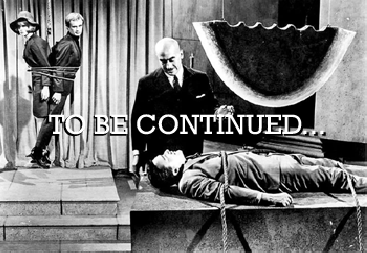

In [21]:
sticthed_image = stitch_strips(page_2_strips)
show_image(sticthed_image)
#sticthed_image

# Manually assigning captions

In [ ]:
display(page_df[page_df.text=='Warstones\xa0Library\xa0'][["x0","y0","x1","y1"]])

bbox = tuple(page_df[page_df.text=='Warstones\xa0Library\xa0'][["x0","y0","x1","y1"]].values[0])
img = closest_image(bbox,images)
img["caption"]='Warstones\xa0Library\xa0'